# Visualizing flags similarity

This notebook demonstrates how multidimensional vectors can be clustered hierarchically based on their euclidean distance, and how these cluster can be visualized using dendograms and matrixes in Python.

The toy example is that of flags appearance, based on their color coordinates.

A more technical and very helpful tutorial can be found at [joernes.de](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)

## Loading flags

Dataset comes from [flagpedia.net](http://flagpedia.net/download) (classical resolution).

I start by loading the flag images from the 'flags' folder into a list, and creating a dictionary to keep track of the country abbreviations (which are given by the filename).

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial import distance

In [2]:
folder='flags'
countries = {}
flags = []

for i, file in enumerate(os.listdir(folder)):
    countries[i] = os.path.splitext(file)[0].upper() # Save name abbreviation in dictionary
    flag = Image.open(os.path.join(folder, file)).convert("RGB")
    flags.append(flag)

C:\Users\Administrator\Anaconda3\lib\site-packages\PIL\Image.py:930: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


I also wrote a function to display n flags side by side, given their indexes. Let's display the first 3. 

In [3]:
def plot_flags(indexes):
    if len(indexes) == 1:
        
        plt.imshow(flags[indexes[0]])
        plt.xlabel(countries[indexes[0]])
        plt.xticks([])
        plt.yticks([])
        return
    
    fig, ax = plt.subplots(1, len(indexes))
    for i, axi in zip(indexes, ax):
        axi.imshow(flags[i])
        axi.set_xlabel(countries[i])
        axi.set_xticks([])
        axi.set_yticks([])

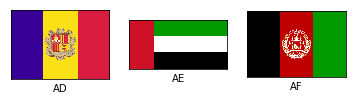

In [4]:
plot_flags([0,1,2])

## Computing vector coordinates for flags

In order to compare different flags, we must measure their appearance somehow. 

I decided to "cut" a flag in several segments, and measure the ammounts of red, green, and blue in each segment.

In the example that follows, the flag of Andorra is divided in 9 pieces, and the proportion of red, green, and blues of each segmented are shown above. It can be seen that blue is the dominant color in the first column (3rd value = 0.57), red in the third column (1st value = 0.85) and red and green (yellow) in the middle column (1st value [0.84-0.97] and 2nd value [0.61-0.86]. 

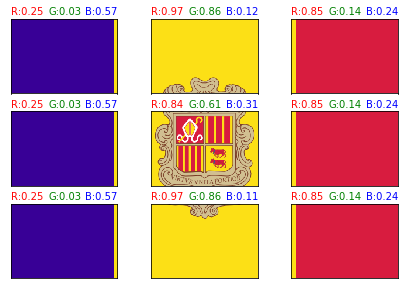

In [5]:
samplesY, samplesX = 3,3

img = np.array(flags[0])
strideY = img.shape[0] // samplesY
strideX = img.shape[1] // samplesX
        
subs = []
flag_vect = []
for i in range(samplesY):
    for j in range(samplesX):
        sub = img[i*strideY:(i+1)*strideY, j*strideX:(j+1)*strideX, :]
        subs.append(sub)
        flag_vect.append([sub[:,:,c].mean()/255 for c in range(3)])

fig, ax = plt.subplots(3,3)
for sub, axi, vect in zip(subs, ax.reshape(-1), flag_vect):
    axi.imshow(sub)      
    axi.text(0,1.05,f'R:{np.round(vect[0], 2)}', color='r', transform=axi.transAxes)
    axi.text(0.35,1.05,f'G:{np.round(vect[1], 2)}', color='g', transform=axi.transAxes)
    axi.text(0.7,1.05,f'B:{np.round(vect[2], 2)}', color='b', transform=axi.transAxes)
    axi.set_xticks([])
    axi.set_yticks([])
plt.tight_layout()

This operation yields a vector of 27 numbers, that characterizes the color "coordinates" of the flag.

I've encapsulated this logic in the **Vectorize()** function. Given any image, it will computes such vector for a specified number of horizontal and vertical slices.

In [6]:
def vectorize(image, slicesY=3, slicesX=3):
        
    img = np.array(image)
    strideY = img.shape[0] // slicesY
    strideX = img.shape[1] // slicesX
        
    vector = []
    for i in range(slicesY):
        for j in range(slicesX):
            for channel in range(3):
                sub = img[i*strideY:(i+1)*strideY, j*strideX:(j+1)*strideX, channel]
                vector.append(sub.mean())
                
    return np.array(vector)/255

In [7]:
andorra_vector = vectorize(flags[0],3 ,3)
print(np.round(andorra_vector, 2))

[0.25 0.03 0.57 0.97 0.86 0.12 0.85 0.14 0.24 0.25 0.03 0.57 0.84 0.61
 0.31 0.85 0.14 0.24 0.25 0.03 0.57 0.97 0.86 0.11 0.85 0.14 0.24]


You can see that these numbers are exactly the same as those in the picture above.

## Using flag vectors to compare flag similarity

Using the same method will yeld different vectors for each flag. This allows me to ask the computer how close are the two vectors by computing the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance). The hope is that this distance will reflect to some extent our intuition of flag similarity.

In the example below I compute the difference between the Andorra flag and that of Romania and Estonia. We expect the first pair to be closer (more similar) than the second. 

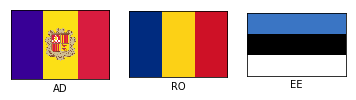

In [8]:
plot_flags([0, 147, 50])

In [9]:
romania_vector = vectorize(flags[147], 3, 3)
estonia_vector = vectorize(flags[50], 3, 3)
print('Romania Vector: ', np.round(romania_vector, 2))
print('Estonia Vector: ', np.round(estonia_vector, 2))

Romania Vector:  [0.   0.17 0.5  0.99 0.82 0.09 0.81 0.07 0.15 0.   0.17 0.5  0.99 0.82
 0.09 0.81 0.07 0.15 0.   0.17 0.5  0.99 0.82 0.09 0.81 0.07 0.15]
Estonia Vector:  [0.23 0.46 0.77 0.23 0.46 0.77 0.23 0.46 0.77 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99]


In [10]:
print('Andorra-Romania distance:', distance.euclidean(andorra_vector, romania_vector))
print('Andorra-Estonia distance:', distance.euclidean(andorra_vector, estonia_vector))

Andorra-Romania distance: 0.6523038805266951
Andorra-Estonia distance: 2.861025120616211


It works! Let's see how it holds for the remaining ones.

## Finding the most similar and dissimilar flags

I decided to take 17 x 17 patches for each flag, in order to encorporate more fine details, such as thin lines, circles and diagonal lines.

In theory I could use all the pixels in the flag, but I feel that this achieves a good compromise between capturing enough attributes of the flag and not be too distracted by minor differences.

Thus, each flag is defined by $17 \times 17 \times 3 = 867$ numbers. This also tells us the largest eucliedean distance that could occur between any two flags (a completely white flag against a completely black one): $\sqrt{867} \approx 29.44$ 

In [11]:
vectors = []
for flag in flags:
    vectors.append(vectorize(flag, 17, 17))

I can now measure the difference between all pairs, to get an idea of their distribution.

In [12]:
distances = []
pairs = []
for i, h1 in enumerate(vectors[:-1]):
    for j, h2 in enumerate(vectors[i+1:]):
        distances.append(distance.euclidean(h1, h2))
        pairs.append([i,i+1+j])
        
distances = np.array(distances)
pairs = np.array(pairs)

Mean: 14.88; Std: 2.57


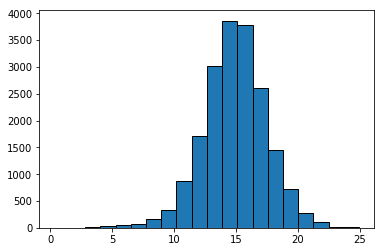

In [13]:
plt.hist(distances, ec='k', bins=20)
print(f"Mean: {np.mean(distances):.2f}; Std: {np.std(distances):.2f}")

On average pairs of flags are separated by 14.88 units (out of the 24.44 possible maximum), with some variability as expected.

So let's find the closest flags.

In [14]:
sort = np.argsort(distances)
sorted_pairs = pairs[sort]

Avg distance: 1.84


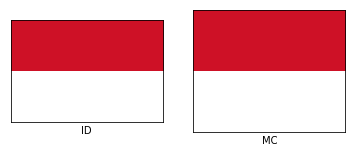

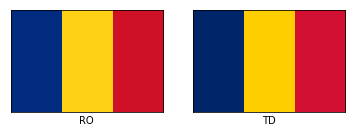

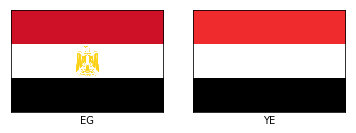

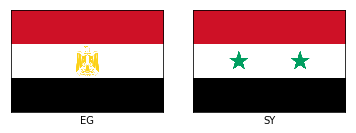

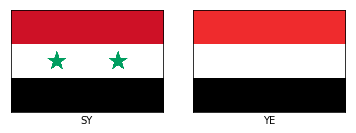

In [15]:
for pair in sorted_pairs[:5]:
    plot_flags(pair)
print(f"Avg distance: {np.mean(distances[sort][:5]):.2f}")

Seems alright. What about those that are most further apart?

Avg distance: 24.59


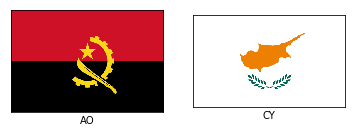

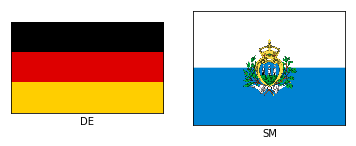

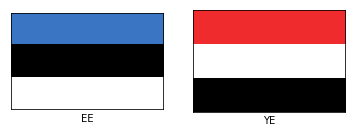

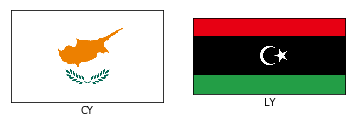

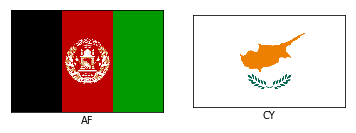

In [16]:
for pair in sorted_pairs[-5:]:
    plot_flags(pair)
print(f"Avg distance: {np.mean(distances[sort][-5:]):.2f}")

Seems alright, except perhaps for the third pair (Estonia - Yemen). They don't seem so different to me, in the sense that they share the very common 3 line horizontal pattern.

This reveals one shortcoming of the method. The way I quantified flag vectors, will lead to an overemphasis of black and white segments that are in different coordinates (note that they are present in moslty non-overlapping regions in all 5 pairs), over other properties of the flag such as having horizontal stripes or central coats of arms.

There are [many other methods](https://en.wikipedia.org/wiki/Feature_detection_(computer_vision)) of describing a picture that can integrate these kinds of aspects. I will however proceed with this, aware of this limitation.

## A detour through Portugal

My own flag is a very contentious case in the world of vexillology. In an attempt to differentiate themselves from the monarchic regime, the republican revolutionaries decided to implement a flag that was drastically different from the [historical ones](https://en.wikipedia.org/wiki/List_of_Portuguese_flags#Historical_flags), which were dominated by white and blue.

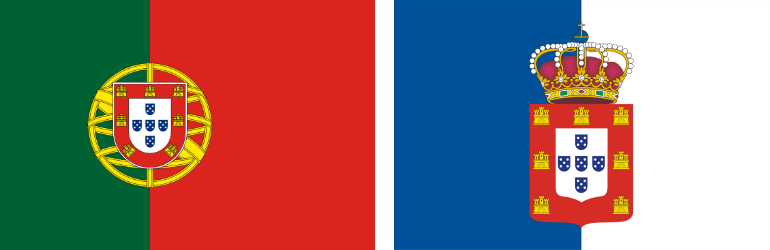

*Current flag shown on the left, and previous one on the right.*

Some people complain that the new flag resembles other Sub-Saharan country flags to which we have no strong cultural ties, others just find the combinations of colors abhorrent (understandigly so). In any case, let's see if the first intuition is captured by our metrics.

### Flags most similar to that of Portugal

In [17]:
countries[143] # Index of the Portuguese Flag is 143

'PT'

In [18]:
indexes_interest = []
for i, (p1, p2) in enumerate(pairs):
    if p1 == 143 or p2 == 143:
        indexes_interest.append(i)
len(indexes_interest)

195

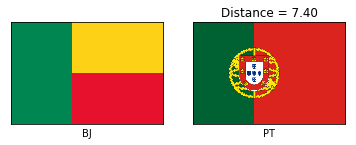

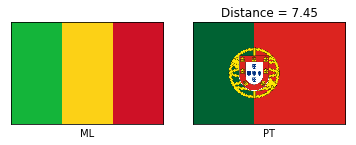

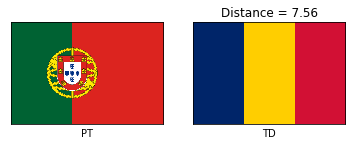

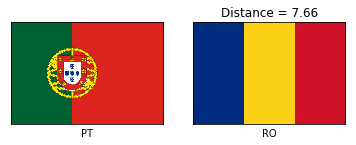

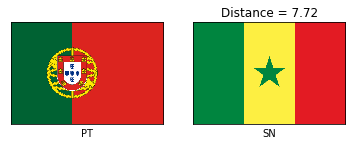

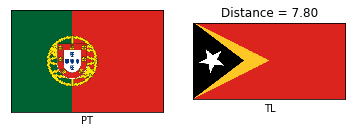

In [19]:
pt_comparisons = distances[indexes_interest] 
pt_pairs = pairs[indexes_interest]
sort = np.argsort(pt_comparisons)
sorted_comparisons = pt_comparisons[sort]
sorted_pairs = pt_pairs[sort]

for pair, dist in zip(sorted_pairs[:6], sorted_comparisons[:6]):
    plot_flags(pair)
    plt.title(f'Distance = {dist:.2f}')

Indeed we find, Benin, Mali and Senegala rank among the top 5 closest flags. And surprisingly to me, so does Romania and Chad. 

**Talk about East Timor**

Now concerning the...

### Flags most distinct from that of Portugal

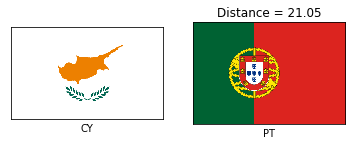

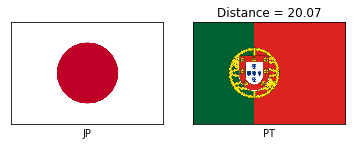

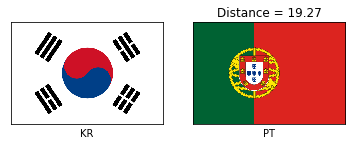

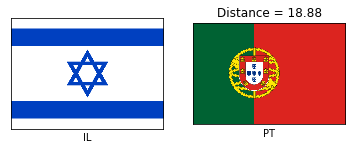

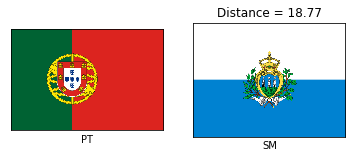

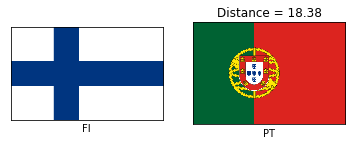

In [20]:
for pair, dist in zip(reversed(sorted_pairs[-6:]), reversed(sorted_comparisons[-6:])):
    plot_flags(pair)
    plt.title(f'Distance = {dist:.2f}')

The results are quite interesting. The whites and blues are clearly a pattern in the distinct flags, suggesting that the Republicans were on the right track to distantiate themselves from the Monarchic pallette. 

But how well did they actually do?

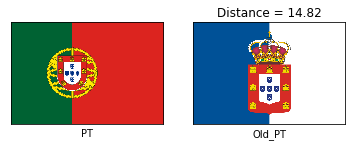

In [21]:
old_flag = Image.open(os.path.join('pt_monarchy.png')).convert("RGB")
flags.append(old_flag)
countries[196] = 'Old_PT'

old_vector = vectorize(old_flag, 17,17)
dist = distance.euclidean(vectors[143], old_vector)

plot_flags([143, 196])
plt.title(f'Distance = {dist:.2f}');

Oh, such an average distance. Why? From the results above, it seems that blue and green are relatively spatially close to each other. 

A much better separation would be attained if the the green and red sides had been flipped.

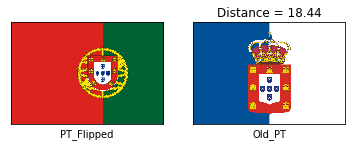

In [22]:
flipped_flag = Image.open(os.path.join('pt_flipped.png')).convert("RGB")
flags.append(flipped_flag)
countries[197] = 'PT_Flipped'

flipped_vector = vectorize(flipped_flag, 17,17)
dist = distance.euclidean(flipped_vector, old_vector)

plot_flags([197, 196])
plt.title(f'Distance = {dist:.2f}');

Even more distinct than the current one is from that of Finland!

Anyway, time to move on to the main goal.

In [23]:
# Delete added entries
flags.pop()
flags.pop()
countries.pop(196);
countries.pop(197);

## Observing all the flags distances at once

It would be cool to be able to see how all the flags are distributed according to this metric. The problem is that it would recquire us to see in 867th dimensions, which obviously cannot be done. 

One ingenious solution is to group the flags hierarchically, and then show the herarchy in a flat screen as a [dendogram](https://en.wikipedia.org/wiki/Dendrogram).

I will employ the [Ward method](https://en.wikipedia.org/wiki/Ward%27s_method), implemented in Scipy, which constrains this hiearchical clustering in an interesting way: at each step merge the two groups that will lead to the least increase in global within-cluster variance.

In [24]:
Z = linkage(vectors, method='ward', metric='euclidean', optimal_ordering=True)

C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


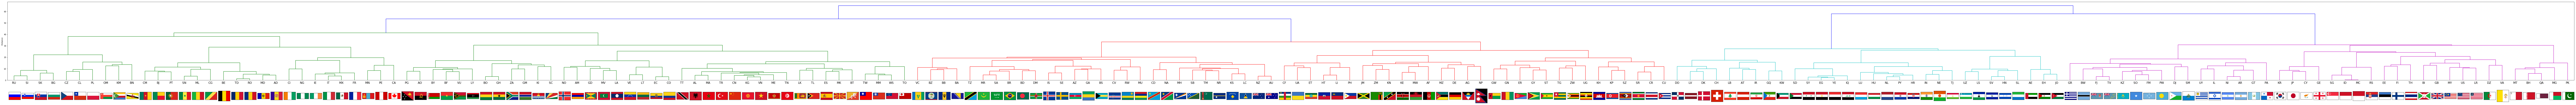

In [25]:
items = 196 # Number of flags shown
item0 = 0   # Index of first flag shown

fig = plt.figure(figsize=(items,8))
axplot = fig.add_axes([0.0,0.25,1,0.75])

# Create dendogram
dend = dendrogram(Z, leaf_rotation=0., leaf_font_size=16.)
plt.xlim([item0*10,item0*10+items*10])

# Change labels into countries abbreviation
locs, labels = plt.xticks()  
plt.xticks(locs, [countries[int(label._text)] for label in labels])
plt.ylabel('Distance')

# Add flags under each label
length = 1/items
spacing = 0.1*length
for k in range(items):
    axicon = fig.add_axes([k*length+spacing,0,length-spacing,0.20])
    axicon.imshow(flags[int(dend['ivl'][k+item0])])
    axicon.set_xticks([])
    axicon.set_yticks([])
    

#fig.savefig('test.png')
fig.show()

The usefulness of this method can be immediatelly appreciated by scrolling through the dendogram horizontal axis. In most case, adjacent flags do look similar. Also, looking vertically, most clusters map nicely to the intuitive sense of similarity (at leas mine's).

There are also some obvious problems. For instance the flags of Portugal and East Timor are separated by nearly 50 other flags, and only become part of the same cluster later on (the 3rd from the last), although they are the most similar to each other.

The problem is that the remaining set of flags that are the most similar to Portugal are not necessarily the most similar to East Timor, and vice-versa. Therefore they end-up in different clusters, and rather spread-out. This is an inevitable fate of trying to obtain a smooth 2D-mapping from the rather complex 867 dimensional space defined by the flag vectors. A similar thing happens when we try to represent our 3D planet in a 2D coordinate system (See wiki: [Coordinate Singularity](https://en.wikipedia.org/wiki/Coordinate_singularity))

Importantly, we can estimate the extent of these "deformations" by calculating the [Cophenetic correlation coefficient](https://en.wikipedia.org/wiki/Cophenetic_correlation), which tells us how close the final dendogram distances between two flags are to the original euclidean distances (a result = 1, would be perfect)

In [26]:
c, _ = cophenet(Z, distance.pdist(vectors))
c

0.5232401920650266

Far from perfect, but good enough for the time being